# 1. Import and clean American Community Survey data

The variables we need from ACS PUMS 2017 personal data is their interview number(SERIALNO), state(ST), citizenship(CIT), sex, age(AGEP), marital stage(MAR), fertility rate within past 12 months(FER), education level(SCHG), income within past 12 months(WAGP &  PINCP), race(RAC1P). 

These data are available at ACS website (https://www.census.gov/programs-surveys/acs/data/pums.html) or American Act Finder (https://factfinder.census.gov/faces/tableservices/jsf/pages/productview.xhtml?pid=ACS_pums_csv_2017&prodType=document).

**Note:Since acs data is too large, I only attached merged data (acs.csv) in my zip. Please skip this part and start from part2.**

In [7]:
import pandas as pd
person17a = pd.read_csv('Z:\\2017ACS\\psam_pusa.csv',usecols=['SERIALNO','ST','CIT','SEX','AGEP',
                                                'MAR','FER','SCHL','WAGP','PINCP','RAC1P'])
person17b = pd.read_csv('Z:\\2017ACS\\psam_pusa.csv',usecols=['SERIALNO','ST','CIT','SEX','AGEP',
                                                'MAR','FER','SCHL','WAGP','PINCP','RAC1P'])
person17 = person17a.append(person17b,ignore_index=True)

The variables we need from household data is income of the whole family and number of own children of an observation.

In [9]:
house17a=pd.read_csv('Z:\\2017ACS\\psam_husa.csv',usecols=['SERIALNO','FINCP','NOC'])
house17b=pd.read_csv('Z:\\2017ACS\\psam_husb.csv',usecols=['SERIALNO','FINCP','NOC'])
house17=house17a.append(house17b,ignore_index=True)

Merge them together then we get data needed.

In [11]:
acs17=person17.merge(house17,on='SERIALNO',how='left') #Merge personal info with household info.
acs17.head()

,SERIALNO,ST,AGEP,CIT,FER,MAR,SCHL,SEX,WAGP,PINCP,RAC1P,FINCP,NOC
0,2017000000016,1,73,1,NaN,4,10.0,1,0.0,10000.0,2,NaN,0.0
1,2017000000031,1,31,1,2.0,5,21.0,2,38500.0,38500.0,1,NaN,0.0
2,2017000000061,1,41,1,NaN,1,17.0,1,72000.0,82000.0,1,90700.0,1.0
3,2017000000061,1,48,1,2.0,1,16.0,2,0.0,8700.0,1,90700.0,1.0
4,2017000000061,1,16,1,NaN,5,13.0,1,0.0,0.0,1,90700.0,1.0


This table only consists of first 28 states. I have to combine them with other 28 states one by one.

In [13]:
acs=[]
for i in range(29,57):
    if (i!=43) & (i!=44) & (i!=52):
        acs.append(pd.read_csv('Z:\\2017ACS\\psam_p'+str(i)+'.csv',usecols=['SERIALNO','ST','CIT','SEX','AGEP',
                                                'MAR','FER','SCHL','WAGP','PINCP','RAC1P']))

In [14]:
house=[]
for i in range(29,57):
    if (i!=43) & (i!=44) & (i!=52):
        house.append(pd.read_csv('Z:\\2017ACS\\psam_h'+str(i)+'.csv',usecols=['SERIALNO','FINCP','NOC']))

In [15]:
data=[]
for i in range(0,25):
    data.append(acs[i].merge(house[i],on='SERIALNO',how='left'))

In [16]:
data[0].dtypes

SERIALNO      int64
ST            int64
AGEP          int64
CIT           int64
FER         float64
MAR           int64
SCHL        float64
SEX           int64
WAGP        float64
PINCP       float64
RAC1P         int64
FINCP       float64
NOC         float64
dtype: object

Everything looks good.

In [17]:
for i in range(0,25):
    acs17=acs17.append(data[i],sort=True)

In [20]:
#acs17.drop('Unnamed: 0',axis=1,inplace=True)
acs17.tail()

,AGEP,CIT,FER,FINCP,MAR,NOC,PINCP,RAC1P,SCHL,SERIALNO,SEX,ST,WAGP
5907,20,1,2.0,NaN,5,NaN,9000.0,1,19.0,2017001534830,2,56,9000.0
5908,18,1,NaN,NaN,5,NaN,4000.0,1,16.0,2017001534957,1,56,0.0
5909,31,1,2.0,NaN,5,NaN,5000.0,9,18.0,2017001535265,2,56,5000.0
5910,60,1,NaN,NaN,3,NaN,2400.0,1,19.0,2017001536156,1,56,2400.0
5911,20,1,NaN,NaN,5,NaN,0.0,1,18.0,2017001536504,1,56,0.0


In [21]:
acs17.to_csv('acs.csv')

# 2. State-level mean personal income and fertility rate of married women
**Start from here!**

In [22]:
import pandas as pd                         # for dealing with data
import numpy as np                          # for using math function
import geopandas                            # for maps work
import matplotlib.pyplot as plt             # for plotting graphes
import seaborn as sns                       # for advanced plotting
import statsmodels.formula.api as smf  # for using specific models from formulas

Select the observations meeting my requirements. Since I want to know something about fertility rate, married women between 18 and 48 years old are most likely to give births.

In [23]:
acs17=pd.read_csv('acs.csv')
#I only need observations who are married female, between 18 and 48 years old.
acs17=acs17[(acs17['SEX']==2)&(acs17['CIT']!=5)&(acs17['AGEP']>=18)&(acs17['AGEP']<=48)&(acs17['MAR']==1)]
acs17=acs17[-acs17['SCHL'].isnull()]
acs17['FER'].replace(2,0,inplace=True) #If they didn't give birth last year then FER=0.
acs17['INCOME']=acs17[['WAGP','PINCP']].max(axis=1) #Take the bigger one in 'personal wage and personal income as one's income
acs17.drop(['Unnamed: 0','SEX','CIT','MAR','WAGP','PINCP'],axis=1,inplace=True)
acs17.rename(columns={'AGEP':'AGE','SCHG':'EDUC','RAC1P':'RACE'},inplace=True)
acs17=acs17[['SERIALNO','ST','AGE','FER','SCHL','RACE','INCOME','FINCP','NOC']]
acs17.head()

,SERIALNO,ST,AGE,FER,SCHL,RACE,INCOME,FINCP,NOC
3,2017000000061,1,48,0.0,16.0,1,8700.0,90700.0,1.0
24,2017000000654,1,42,0.0,19.0,1,0.0,49700.0,2.0
33,2017000000695,1,35,0.0,17.0,1,20100.0,20100.0,3.0
44,2017000000812,1,25,0.0,20.0,1,19500.0,47500.0,0.0
55,2017000001602,1,44,0.0,22.0,1,51000.0,104000.0,1.0


In [24]:
print(acs17.dtypes)
print(acs17.shape)

SERIALNO      int64
ST            int64
AGE           int64
FER         float64
SCHL        float64
RACE          int64
INCOME      float64
FINCP       float64
NOC         float64
dtype: object
(369383, 9)


Make a resonable category for education attainment. 
<br>0: not have been to primary school.
<br>1~11: Grade 1 to Grade 11
<br>12: Grade 12 without high school diplomas
<br>13: Grade 12 with high school diplomas
<br>14: Some college
<br>15: Bachelor's degree and equivalents
<br>16: Master's and professional degree (above bachelor)
<br>17: PhD degree and above

In [25]:
acs17['SCHL']=acs17['SCHL'].map({1:0, 2:0, 3:0, 4:1, 5:2, 6:3, 7:4, 8:5, 9:6, 10:7, 11:8, 12:9, 13:10, 14:11, 15:12, 16:13,
                                 17:13, 18:14 ,19:14,20:14, 21:15, 22:16, 23:16, 24:17})
acs17.dropna(inplace=True)

In [26]:
codes=pd.read_csv('codes.csv') #To specify states name.
print(codes.dtypes)

Name    object
ST      object
code     int64
dtype: object


In [27]:
codes.drop('Name',axis=1,inplace=True)
codes.rename(columns={'ST':'STATE','code':'ST'},inplace=True)
df=pd.merge(acs17,codes,on='ST',how='left')
df.head()

,SERIALNO,ST,AGE,FER,SCHL,RACE,INCOME,FINCP,NOC,STATE
0,2017000000061,1,48,0.0,13,1,8700.0,90700.0,1.0,AL
1,2017000000654,1,42,0.0,14,1,0.0,49700.0,2.0,AL
2,2017000000695,1,35,0.0,13,1,20100.0,20100.0,3.0,AL
3,2017000000812,1,25,0.0,14,1,19500.0,47500.0,0.0,AL
4,2017000001602,1,44,0.0,16,1,51000.0,104000.0,1.0,AL


I want to know if there is some relationship between and fertility rate and personal income level.

In [28]:
df=df.dropna()
a=df.groupby('STATE')[['FER','INCOME','FINCP']].mean()
a.head(10)

,FER,INCOME,FINCP
STATE,,,
AK,0.117988,35466.266925,108640.793037
AL,0.078009,29290.694888,94085.080937
AR,0.082698,29731.099157,90669.670012
AZ,0.090698,36538.101057,111744.692600
CA,0.085809,46480.141798,143682.606387
CO,0.090855,42600.955459,127799.524438
CT,0.086659,53320.112858,166653.458283
DC,0.104895,84785.202797,211700.275058
DE,0.079932,49170.918367,131683.571429


But the relationship is not very clear in this table. We can first plot them out first. Besides, I should consider more factors that affect fertility rate since it is a very serious decison for a family. I'll do a regression afterwards.

In [29]:
#Import states geo dataframe.
states =  geopandas.read_file('cb_2016_us_state_5m.shp')#In order to plot a map with mean fertility rate.
states.head(5)

,STATEFP,STATENS,AFFGEOID,GEOID,STUSPS,NAME,LSAD,ALAND,AWATER,geometry
0,01,01779775,0400000US01,01,AL,Alabama,00,131173688951,4593686489,"(POLYGON ((-88.04374299999999 30.517423, -88.0..."
1,02,01785533,0400000US02,02,AK,Alaska,00,1477946266785,245390495931,"(POLYGON ((-133.655819 55.625617, -133.624921 ..."
2,04,01779777,0400000US04,04,AZ,Arizona,00,294198560125,1027346486,"POLYGON ((-114.799683 32.593621, -114.809393 3..."
3,08,01779779,0400000US08,08,CO,Colorado,00,268429343790,1175112870,"POLYGON ((-109.060253 38.599328, -109.059541 3..."
4,09,01779780,0400000US09,09,CT,Connecticut,00,12542638347,1815476291,"POLYGON ((-73.72777499999999 41.100696, -73.69..."


In [30]:
states.rename(columns={'GEOID':'ST','STUSPS':'STATE'},inplace=True)
states=states[-states['STATE'].isin(['GU', 'MP', 'AS', 'PR', 'VI', 'AK', 'HI'])]

In [31]:
a=pd.merge(a,states,on='STATE',how='inner')
a=geopandas.GeoDataFrame(a, geometry = 'geometry') #Make the dataset to be a geo dataframe so we can plot it as a map.
a=a[-a['STATE'].isin(['GU', 'MP', 'AS', 'PR', 'VI', 'AK', 'HI'])]#Only take a look at US mainland.
type(a)

geopandas.geodataframe.GeoDataFrame

In [32]:
a['FER']=a['FER']*1000 #Fertility rate is usually interpreted as how many children do 1000 women give births to.

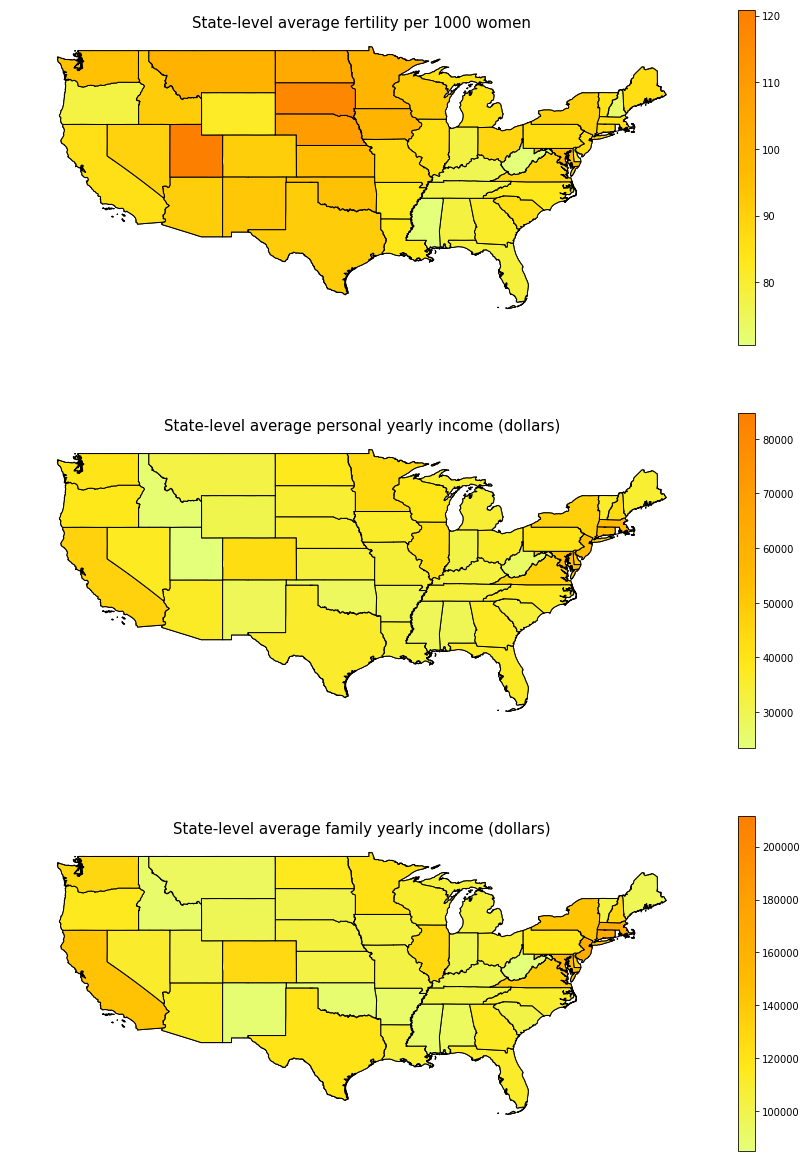

In [33]:
fig,gax = plt.subplots(3,1,figsize=(15,21))

states.plot(ax=gax[0], edgecolor='black', color='white')
a.plot(ax=gax[0], column='FER', legend=True, cmap='Wistia', edgecolor='black')

states.plot(ax=gax[1], edgecolor='black', color='white')
a.plot(ax=gax[1], column='INCOME',legend=True, cmap='Wistia',edgecolor='black')

states.plot(ax=gax[2], edgecolor='black', color='white')
a.plot(ax=gax[2], column='FINCP',legend=True, cmap='Wistia',edgecolor='black')
    
gax[0].set_title('State-level average fertility per 1000 women',fontsize=15)
gax[0].axis('off')
gax[0].text

gax[1].set_title('State-level average personal yearly income (dollars)',fontsize=15)
gax[1].axis('off')

gax[2].set_title('State-level average family yearly income (dollars)',fontsize=15)
gax[2].axis('off')

plt.show()
#fig.savefig('map.png')

We can see from the graphs above that in midwest states more new babies were born than those in states near coasts.
Roughly, it looks like that the women in those most productive states are earning less money. This makes sense because giving birth takes too much efforts and too long time for women. However, fertily rate seems still not positively related to family income.

# 3. A direct relationship between fertility and income

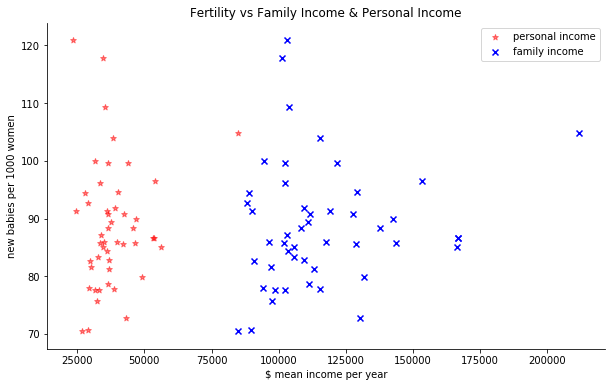

In [34]:
fig,ax=plt.subplots(figsize=(10,6))
ax.scatter(a['INCOME'],a['FER'], color='red',marker='*',alpha = 0.5,label = 'personal income')  
ax.scatter(a['FINCP'], a['FER'], color='blue',marker='x',label = 'family income')
sns.despine()
ax.set_xlabel('$ mean income per year')
ax.set_ylabel('new babies per 1000 women')
ax.set_title('Fertility vs Family Income & Personal Income')
ax.legend()
#fig.savefig('scatter.png')

It seems like there is no linear relationship between these variables.

In [35]:
res1=smf.ols('FER~INCOME',data=acs17).fit()
print(res1.summary())

#I used codes below to output as a latex file. No need to run these line.


#f1 = open('reg1.tex', 'w')
#f1.write(beginningtex)
#f1.write(res1.summary().as_latex())
#f1.write(endtex)
#f1.close()

                            OLS Regression Results                            
Dep. Variable:                    FER   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     254.2
Date:                Fri, 14 Dec 2018   Prob (F-statistic):           3.24e-57
Time:                        21:43:52   Log-Likelihood:                -55156.
No. Observations:              364919   AIC:                         1.103e+05
Df Residuals:                  364917   BIC:                         1.103e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0925      0.001    157.146      0.0

In [36]:
res2=smf.ols('FER~FINCP',data=acs17).fit()
print(res2.summary())

                            OLS Regression Results                            
Dep. Variable:                    FER   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     271.7
Date:                Fri, 14 Dec 2018   Prob (F-statistic):           5.20e-61
Time:                        21:43:52   Log-Likelihood:                -55147.
No. Observations:              364919   AIC:                         1.103e+05
Df Residuals:                  364917   BIC:                         1.103e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0956      0.001    135.023      0.0

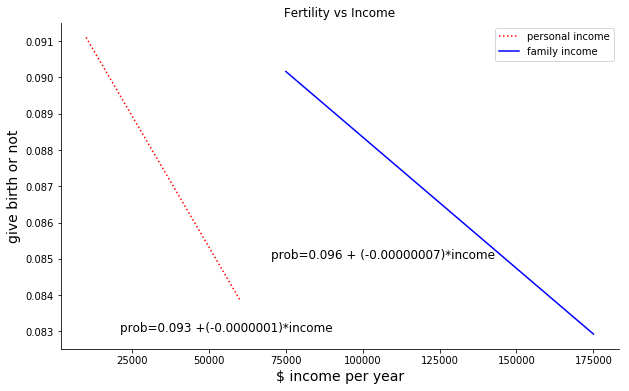

In [37]:
fig,ax = plt.subplots(figsize=(10,6))

p1=res1.params
x1=range(10000,60000)
y1=[p1.Intercept + p1.INCOME*i for i in x1]

p2=res2.params
x2=range(75000,175000)
y2=[p2.Intercept + p2.FINCP*i for i in x2]

ax.plot(x1,y1,color='red',linestyle=':',label='personal income')
ax.plot(x2,y2,color='blue',label='family income')
text1 = 'prob=%.3f +(%.7f)*income '%(p1.Intercept, p1.INCOME)
text2 = 'prob=%.3f + (%.8f)*income '%(p2.Intercept, p2.FINCP)
ax.text(21000,0.083,text1,fontsize=12)
ax.text(70000,0.085,text2,fontsize=12)

ax.set_xlabel('$ income per year', fontsize=14)
ax.set_ylabel('give birth or not', fontsize=14)
ax.set_title('Fertility vs Income')
ax.legend()

sns.despine()

#fig.savefig('plot.png')

I ran the logit regression as well to check if they have the same tendency.

In [38]:
reg_log1 = smf.logit('FER~INCOME',data=acs17).fit()
print(reg_log1.summary())

Optimization terminated successfully.
         Current function value: 0.294689
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                    FER   No. Observations:               364919
Model:                          Logit   Df Residuals:                   364917
Method:                           MLE   Df Model:                            1
Date:                Fri, 14 Dec 2018   Pseudo R-squ.:                0.001340
Time:                        21:44:01   Log-Likelihood:            -1.0754e+05
converged:                       True   LL-Null:                   -1.0768e+05
                                        LLR p-value:                 1.034e-64
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -2.2701      0.008   -295.601      0.000      -2.285      -2.255
INCOME     -2.214e-06   1.39e

In [39]:
reg_log2 = smf.logit('FER~FINCP',data=acs17).fit()
print(reg_log2.summary())

Optimization terminated successfully.
         Current function value: 0.294676
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                    FER   No. Observations:               364919
Model:                          Logit   Df Residuals:                   364917
Method:                           MLE   Df Model:                            1
Date:                Fri, 14 Dec 2018   Pseudo R-squ.:                0.001383
Time:                        21:44:07   Log-Likelihood:            -1.0753e+05
converged:                       True   LL-Null:                   -1.0768e+05
                                        LLR p-value:                 9.261e-67
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -2.2303      0.009   -239.846      0.000      -2.249      -2.212
FINCP      -1.052e-06   6.39e

# 4. Relationships between fertility rate, education level and age

We believe that the more one is educated, the greater ability he/she gains and the higher salary he/she would earn as well. We can then delude that a women with a higher diploma is less likely to give a birth. However, we also knows that as people age, they are more experienced thus earning more. Does aging also lead to low fertility? We can see if it's true from contrasting graph.

In [40]:
educ = pd.cut(
    df['SCHL'],
    [-np.inf, 0, 12, 14,15, np.inf],
    labels=['no-school', 'HS-', 'HS','College','Graduate+'],   
    #'HS-' means less than high school, 'Graduate+' means graduate and above
    right = True
)
educ.dtypes

CategoricalDtype(categories=['no-school', 'HS-', 'HS', 'College', 'Graduate+'], ordered=True)

In [41]:
age = pd.cut(
    df['AGE'],
    [17,27,37,48],
    labels=['young', 'middle', 'senior'], # I believe middle group may have the highest fertility rate.
    right = True
)

In [42]:
b = df.groupby([age,educ])['FER'].agg(['count','mean'])
b['mean']=b['mean']*1000
b

count        mean
AGE    SCHL                        
young  no-school    248  217.741935
       HS-         2270  216.299559
       HS         25123  198.981013
       College     9661  146.775696
       Graduate+   2251  105.286539
middle no-school    690  172.463768
       HS-         4954  110.012111
       HS         64265  115.895122
       College    43389  160.870267
       Graduate+  27740  177.901947
senior no-school   1408   26.278409
       HS-         7809   24.074786
       HS         86811   18.223497
       College    51293   28.054510
       Graduate+  37007   32.561407

In [43]:
b.reset_index(inplace=True)
b.rename(columns={'mean':'Fertility',"SCHL":'Education level'},inplace=True)

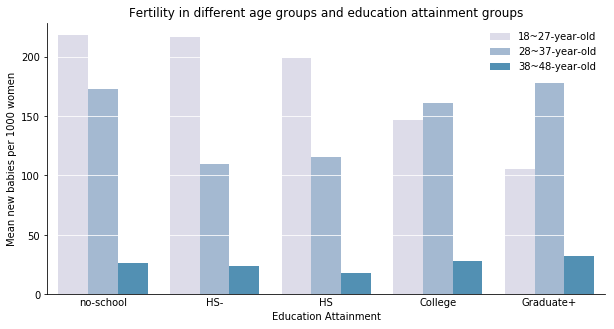

In [44]:
f,ax = plt.subplots(figsize=(10,5))

sns.barplot(x='Education level', y = 'Fertility', hue='AGE', data=b, ax=ax, palette =sns.color_palette("PuBu",4))
sns.despine() 

ax.set_xlabel('Education Attainment')  
ax.set_ylabel('Mean new babies per 1000 women')

sns.set_context("notebook", font_scale=1, rc={"lines.linewidth": 2.5})

ax.legend().set_title('')
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, ['18~27-year-old','28~37-year-old','38~48-year-old'], frameon=False, ncol=1, loc='upper right')
ax.grid(axis='y', color='white')
ax.xaxis.set_tick_params(length=0) 
ax.set_title('Fertility in different age groups and education attainment groups')

#f.savefig('bar.png')

# 5. Logit regression model

In [45]:
c=acs17.copy()
edu = pd.cut(
    c['SCHL'],
    [-np.inf, 0, 12, 14,15, np.inf],
    labels=['no-school', 'HS-', 'HS','College','Graduate+'],   
    #'HS-' means less than high school, 'Graduate+' means graduate and above
    right = True
)
c['EDUC']=edu

In [46]:
c.dtypes

SERIALNO       int64
ST             int64
AGE            int64
FER          float64
SCHL           int64
RACE           int64
INCOME       float64
FINCP        float64
NOC          float64
EDUC        category
dtype: object

In [47]:
res = smf.logit('FER ~ AGE+INCOME+FINCP+NOC+C(EDUC)', data=c).fit()

print(res.summary())
print()

#Codes below are used to output summary as a Latex file used in the report. No need to run.
beginningtex = """\\documentclass{report}
\\usepackage{booktabs}
\\begin{document}"""
endtex = "\end{document}"

#f3 = open('res_log.tex', 'w')
#f3.write(beginningtex)
#f3.write(res.summary().as_latex())
#f3.write(endtex)
#f3.close()

Optimization terminated successfully.
         Current function value: 0.250269
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:                    FER   No. Observations:               364919
Model:                          Logit   Df Residuals:                   364910
Method:                           MLE   Df Model:                            8
Date:                Fri, 14 Dec 2018   Pseudo R-squ.:                  0.1519
Time:                        21:44:14   Log-Likelihood:                -91328.
converged:                       True   LL-Null:                   -1.0768e+05
                                        LLR p-value:                     0.000
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept                2.4079      0.086     27.968      0.000       2.239       2.577

It is impossible to interpret the logit model with so many variables. However we can predict the probability in given case.

Case1: Two observations who both graduated from a college, 24-year-old, married, having no child, having same family income 100,000 dollars per year but NO.1 earning 30,000 dollars per year and NO.2 40,000 dollars per year.

Case2: Two observations who both graduated from a college, 24-year-old, married, having no child, earning 40,000 dollars per year but NO.1 having 100,000 dollars family income and NO.2 having 110,000 dollars.

In [64]:
test1=[['College',24,30000,100000,0],['College',24,40000,100000,0]]
test1=pd.DataFrame(test1,columns=['EDUC','AGE','INCOME','FINCP','NOC'])

test2=[['College',24,40000,100000,0],['College',24,40000,110000,0]]
test2=pd.DataFrame(test2,columns=['EDUC','AGE','INCOME','FINCP','NOC'])

In [60]:
pred1=res.predict(test1)
print(type(pred1))
print(pred1)

<class 'pandas.core.series.Series'>
0    0.213056
1    0.213546
dtype: float64


In [65]:
pred2=res.predict(test2)
print(pred2)

0    0.213546
1    0.214629
dtype: float64


In [68]:
print('In case 1, NO.1 has probability of %.2f percent to give a birth and NO.2 has a probability of %.2f percent,\
%.2f percent higher.'%(pred1[0]*100,pred1[1]*100,(pred1[1]-pred1[0])*100))
print('In case 2, NO.1 has probability of %.2f percent to give a birth and NO.2 has a probability of %.2f percent,\
%.2f percent higher.'%(pred2[0]*100,pred2[1]*100,(pred2[1]-pred2[0])*100))

In case 1, NO.1 has probability of 21.31 percent to give a birth and NO.2 has a probability of 21.35 percent,0.05 percent higher.
In case 2, NO.1 has probability of 21.35 percent to give a birth and NO.2 has a probability of 21.46 percent,0.11 percent higher.
